In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('spectrograms.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 78


In [4]:
def max_multiple(number, base=4):
    return base * int(number/base)

min_x, min_y = min(specgram.shape[1] for specgram in specgrams), specgrams[0].shape[0]
min_x_mult, min_y_mult, min_x_50 = max_multiple(min_x), max_multiple(min_x), int(1.5*min_x)
print(min_x, min_y)
print(min_x_mult, min_y_mult, min_x_50)

68 64
68 68 102


In [5]:
# Reshape spectrograms by limiting number of columns to a max
reshape = []
for specgram in specgrams:
    reshape.append(specgram[:min_y_mult, :min_x_mult])
    if specgram.shape[1] > min_x_50:
        reshape.append(specgram[:min_y_mult, -min_x_mult:])  # if columns is > 1.5*min_size, append the last min_size columns

#Flip
augment = []
for specgram in reshape:
    augment.append(specgram)
    augment.append(np.flip(specgram, 0))  # flip rows / y axis
    augment.append(np.flip(specgram, 1))  # flip columns / x axis
    augment.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

print(len(augment))

384


In [6]:
# Obtain 3 dimensional shape
dim = augment[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(64, 68, 1)


In [7]:
# Split dataset between train and test
X_train, X_test = train_test_split(augment, test_size=0.25, shuffle=False)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 288
Test samples: 96


In [8]:
# Add gaussian noise
noise_factor = 0.1

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

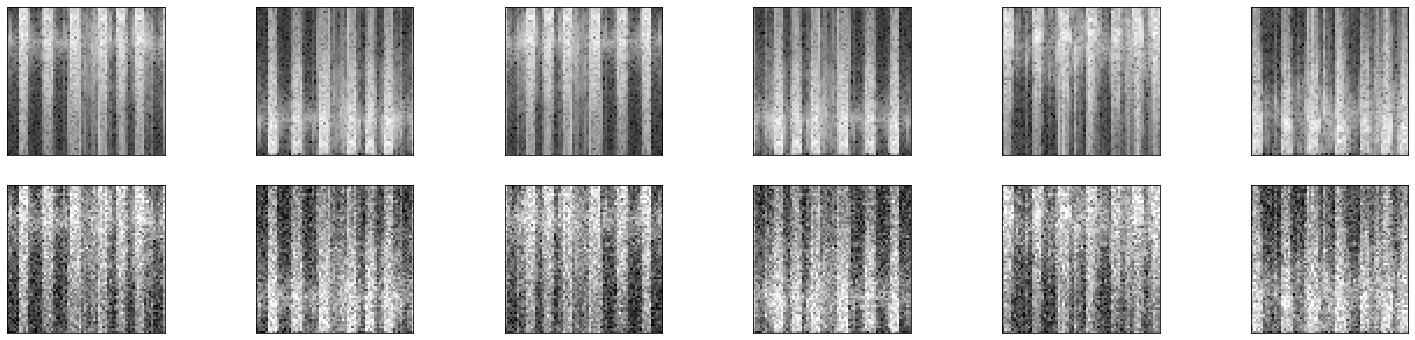

In [9]:
# Visualize original x noisy
n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_train_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [10]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

## Autoencoder Model

In [11]:
# input_img = Input(shape=dim)
# n_features = 32

# # encoder
# ## conv.layers
# code = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(8, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# # code = Conv2D(4, kernel_size=(3, 4), padding='valid', activation='relu')(code)

# ## dense.layers
# code = Flatten()(code)
# # code = Dropout(0.25)(code)
# # code = Dense(n_features * 64, activation='relu')(code)
# # code = Dense(n_features * 16, activation='relu')(code)
# # code = Dense(n_features * 4, activation='relu')(code)
# bottleneck = Dense(n_features, activation='relu')(code)  # bottleneck

# # decoder
# ## dense.layers
# # x_hat = Dense(n_features * 4, activation='relu')(bottleneck)
# # x_hat = Dense(n_features * 16, activation='relu')(x_hat)
# # x_hat = Dense(n_features * 64, activation='relu')(x_hat)
# x_hat = Dense(512, activation='relu')(bottleneck)

# ## conv.layers
# x_hat = Reshape((8, 8, 8))(x_hat)
# x_hat = UpSampling2D((2, 2))(x_hat)
# x_hat = Conv2DTranspose(16, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
# x_hat = Conv2DTranspose(16, kernel_size=(1, 2), padding='valid', activation='relu')(x_hat)
# x_hat = UpSampling2D((2, 2))(x_hat)
# x_hat = Conv2DTranspose(32, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
# x_hat = UpSampling2D((2, 2))(x_hat)
# x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

# autoencoder = Model(input_img, x_hat)
# autoencoder.summary()

In [12]:
input_img = Input(shape=dim)
n_features = 32

# encoder
## conv.layers
code = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(8, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(4, kernel_size=(3, 4), padding='valid', activation='relu')(code)

## dense.layers
bottleneck = Flatten()(code)
# code = Dropout(0.25)(code)
# code = Dense(n_features * 64, activation='relu')(code)
# code = Dense(n_features * 16, activation='relu')(code)
# code = Dense(n_features * 4, activation='relu')(code)
# bottleneck = Dense(n_features, activation='relu')(code)  # bottleneck

# decoder
## dense.layers
# x_hat = Dense(n_features * 4, activation='relu')(bottleneck)
# x_hat = Dense(n_features * 16, activation='relu')(x_hat)
# x_hat = Dense(n_features * 64, activation='relu')(x_hat)
# x_hat = Dense(2176, activation='relu')(bottleneck)

## conv.layers
x_hat = Reshape((16, 17, 8))(bottleneck)
# x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(16, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
# x_hat = Conv2DTranspose(16, kernel_size=(1, 2), padding='valid', activation='relu')(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(32, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 68, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 68, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 34, 16)        12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 17, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 17, 8)         3208      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
__________

In [13]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 50

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit([X_train_noisy], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=([X_test_noisy], [X_test]))

Train on 288 samples, validate on 96 samples
Epoch 1/50
288/288 [==============================] - 3s 9ms/step - loss: 0.0351 - val_loss: 0.0318
Epoch 2/50
288/288 [==============================] - 3s 9ms/step - loss: 0.0298 - val_loss: 0.0313
Epoch 3/50
288/288 [==============================] - 2s 9ms/step - loss: 0.0293 - val_loss: 0.0310
Epoch 4/50
288/288 [==============================] - 2s 9ms/step - loss: 0.0287 - val_loss: 0.0324
Epoch 5/50
288/288 [==============================] - 2s 8ms/step - loss: 0.0286 - val_loss: 0.0320
Epoch 6/50
288/288 [==============================] - 2s 9ms/step - loss: 0.0287 - val_loss: 0.0299
Epoch 7/50
288/288 [==============================] - 2s 8ms/step - loss: 0.0278 - val_loss: 0.0329
Epoch 8/50
288/288 [==============================] - 2s 8ms/step - loss: 0.0270 - val_loss: 0.0279
Epoch 9/50
288/288 [==============================] - 2s 8ms/step - loss: 0.0276 - val_loss: 0.0275
Epoch 10/50
288/288 [==============================] - 

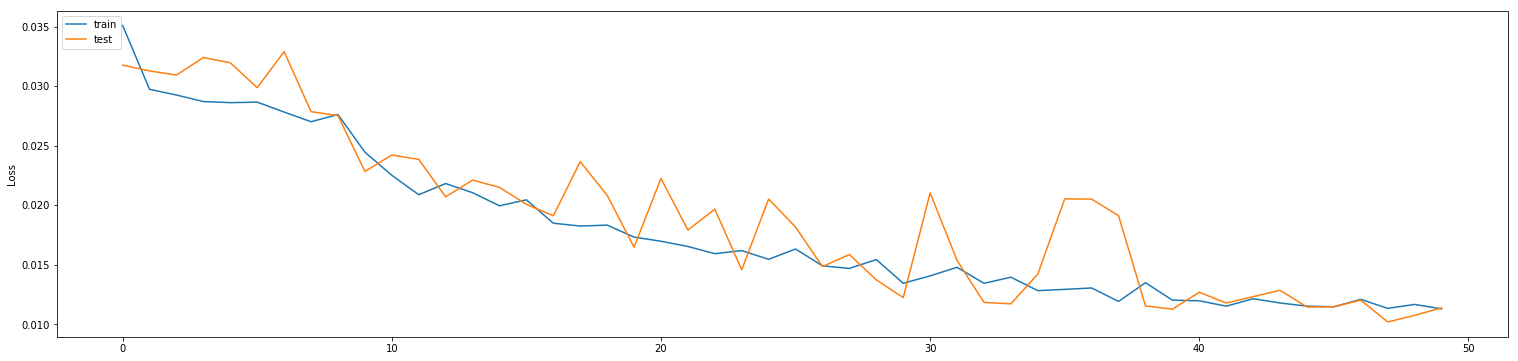

In [14]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

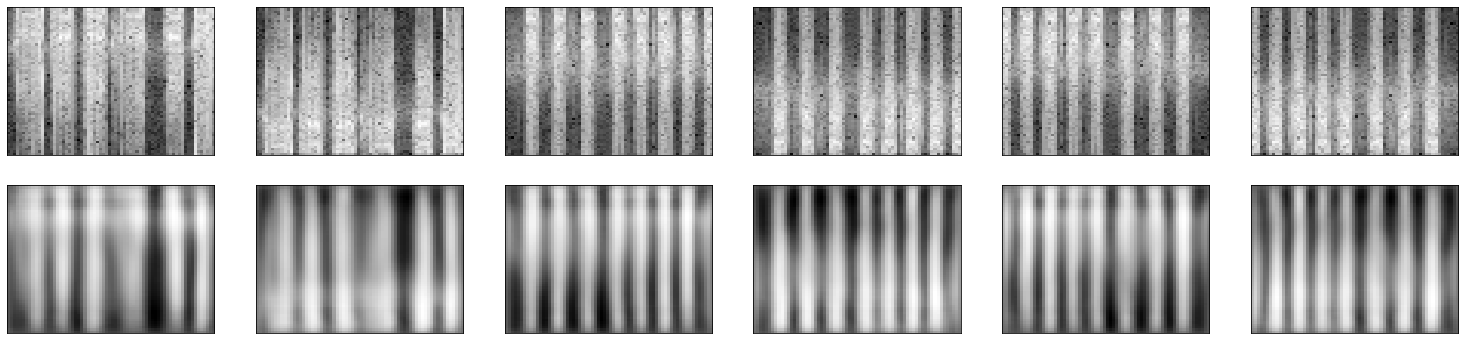

In [15]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

start, stop = 10, 16
for i, n in enumerate(range(start, stop), start=1):
    ax = plt.subplot(2, stop-start, i)
    plt.imshow(decoded_test[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, stop-start, i+stop-start)
    plt.imshow(decoded_predictions[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Utilizando o bottleneck para extracação de features

In [16]:
encoder = Model(input_img, bottleneck)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 68, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 68, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 34, 16)        12816     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 17, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 17, 8)         3208      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
Total para

In [17]:
features = encoder.predict([X_test])
df = pd.DataFrame(features)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175
count,96.0,96.0,96.000000,96.0,96.000000,96.000000,96.000000,96.000000,96.0,96.0,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.0,0.0,0.268211,0.0,0.004749,0.357444,0.001114,0.013884,0.0,0.0,...,0.529582,0.172547,0.210656,0.000033,0.002846,0.278995,0.164488,0.000923,0.539757,0.111219
std,0.0,0.0,0.218720,0.0,0.016735,0.201142,0.004973,0.024378,0.0,0.0,...,0.203204,0.084770,0.098444,0.000327,0.013261,0.174317,0.087241,0.009048,0.242958,0.063467
min,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.084970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.057916,0.0,0.000000,0.200185,0.000000,0.000000,0.0,0.0,...,0.367288,0.102973,0.135006,0.000000,0.000000,0.126013,0.092208,0.000000,0.364661,0.067075
50%,0.0,0.0,0.257984,0.0,0.000000,0.366542,0.000000,0.000000,0.0,0.0,...,0.556610,0.179524,0.211313,0.000000,0.000000,0.278613,0.160413,0.000000,0.547977,0.127885
75%,0.0,0.0,0.463644,0.0,0.000000,0.529663,0.000000,0.021795,0.0,0.0,...,0.667318,0.239477,0.289641,0.000000,0.000000,0.403832,0.223724,0.000000,0.738750,0.167731
max,0.0,0.0,0.719909,0.0,0.105877,0.694200,0.036006,0.115352,0.0,0.0,...,0.889615,0.315912,0.399869,0.003200,0.092238,0.615139,0.352294,0.088648,0.961783,0.203576


In [18]:
df

,0,1,2,3,4,5,6,7,8,9,...,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175
0,0.0,0.0,0.453269,0.0,0.000000,0.523216,0.000000,0.029025,0.0,0.0,...,0.508613,0.178674,0.227193,0.0000,0.000000,0.283089,0.163335,0.000000,0.694351,0.133743
1,0.0,0.0,0.254425,0.0,0.000000,0.298096,0.000000,0.000000,0.0,0.0,...,0.746632,0.272556,0.302583,0.0000,0.000000,0.403580,0.232160,0.000000,0.923322,0.173780
2,0.0,0.0,0.473969,0.0,0.000000,0.565871,0.000000,0.000000,0.0,0.0,...,0.353637,0.096141,0.118433,0.0000,0.000000,0.344032,0.205686,0.000000,0.396245,0.142456
3,0.0,0.0,0.265812,0.0,0.000000,0.369118,0.000000,0.000000,0.0,0.0,...,0.557463,0.154867,0.197916,0.0000,0.000000,0.559749,0.287745,0.000000,0.608269,0.187843
4,0.0,0.0,0.348591,0.0,0.000000,0.427547,0.000000,0.000000,0.0,0.0,...,0.398858,0.043145,0.095732,0.0000,0.000000,0.278557,0.226398,0.000000,0.454493,0.112086
5,0.0,0.0,0.000000,0.0,0.054255,0.000000,0.014583,0.000000,0.0,0.0,...,0.611319,0.180727,0.288239,0.0000,0.000000,0.612193,0.352294,0.000000,0.910728,0.195419
6,0.0,0.0,0.608039,0.0,0.000000,0.685943,0.000000,0.005831,0.0,0.0,...,0.251170,0.010626,0.063729,0.0000,0.000000,0.000000,0.071486,0.000000,0.070722,0.000000
7,0.0,0.0,0.136699,0.0,0.000000,0.254467,0.000000,0.000000,0.0,0.0,...,0.579753,0.198759,0.258249,0.0000,0.000000,0.260600,0.192036,0.000000,0.559248,0.110911
8,0.0,0.0,0.616628,0.0,0.000000,0.651869,0.000000,0.004949,0.0,0.0,...,0.464138,0.123704,0.224326,0.0000,0.000000,0.121288,0.092298,0.000000,0.402734,0.051431
9,0.0,0.0,0.215649,0.0,0.000000,0.269422,0.000000,0.000000,0.0,0.0,...,0.805421,0.239158,0.329262,0.0000,0.000000,0.476243,0.222833,0.000000,0.907368,0.159439


### From here onwards a label and predicted label was added randomly for testing ROC curve and AUC percentage

In [19]:
# Assign 0 or 1 integer to Label, 0~1 float to Prediction and insert into dataframe
Label = np.random.randint(2, size=len(df))
# Predicted = [np.random.random_sample()/2 + 0.5 if l == 1 else np.random.random_sample()/2 for l in Label] # 100% acurate
Predicted = np.random.random_sample(size=len(df)) # completely random

df = df.assign(Label=Label)
df = df.assign(Predicted=Predicted)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2168,2169,2170,2171,2172,2173,2174,2175,Label,Predicted
0,0.0,0.0,0.453269,0.0,0.000000,0.523216,0.000000,0.029025,0.0,0.0,...,0.227193,0.0,0.0,0.283089,0.163335,0.0,0.694351,0.133743,1,0.050832
1,0.0,0.0,0.254425,0.0,0.000000,0.298096,0.000000,0.000000,0.0,0.0,...,0.302583,0.0,0.0,0.403580,0.232160,0.0,0.923322,0.173780,1,0.015083
2,0.0,0.0,0.473969,0.0,0.000000,0.565871,0.000000,0.000000,0.0,0.0,...,0.118433,0.0,0.0,0.344032,0.205686,0.0,0.396245,0.142456,0,0.532493
3,0.0,0.0,0.265812,0.0,0.000000,0.369118,0.000000,0.000000,0.0,0.0,...,0.197916,0.0,0.0,0.559749,0.287745,0.0,0.608269,0.187843,0,0.084536
4,0.0,0.0,0.348591,0.0,0.000000,0.427547,0.000000,0.000000,0.0,0.0,...,0.095732,0.0,0.0,0.278557,0.226398,0.0,0.454493,0.112086,0,0.499347
5,0.0,0.0,0.000000,0.0,0.054255,0.000000,0.014583,0.000000,0.0,0.0,...,0.288239,0.0,0.0,0.612193,0.352294,0.0,0.910728,0.195419,1,0.906917
6,0.0,0.0,0.608039,0.0,0.000000,0.685943,0.000000,0.005831,0.0,0.0,...,0.063729,0.0,0.0,0.000000,0.071486,0.0,0.070722,0.000000,0,0.080659
7,0.0,0.0,0.136699,0.0,0.000000,0.254467,0.000000,0.000000,0.0,0.0,...,0.258249,0.0,0.0,0.260600,0.192036,0.0,0.559248,0.110911,0,0.300604
8,0.0,0.0,0.616628,0.0,0.000000,0.651869,0.000000,0.004949,0.0,0.0,...,0.224326,0.0,0.0,0.121288,0.092298,0.0,0.402734,0.051431,0,0.846854
9,0.0,0.0,0.215649,0.0,0.000000,0.269422,0.000000,0.000000,0.0,0.0,...,0.329262,0.0,0.0,0.476243,0.222833,0.0,0.907368,0.159439,0,0.343788


Area Underneath Curve percentage (AUC): 0.4843478260869565


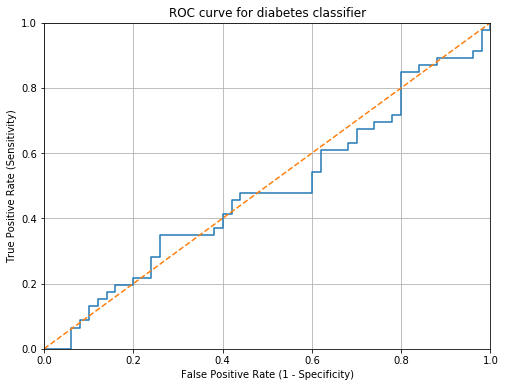

In [20]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(df['Label'].values, df['Predicted'].values)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('Area Underneath Curve percentage (AUC):', metrics.roc_auc_score(df['Label'].values, df['Predicted'].values))

In [21]:
data = {'Threshold':thresholds, 'True Positive':tpr, 'False Positive':fpr}
df2 = pd.DataFrame(data)
df2

,Threshold,True Positive,False Positive
0,1.993404,0.000000,0.00
1,0.993404,0.000000,0.02
2,0.980551,0.000000,0.06
3,0.906917,0.065217,0.06
4,0.906606,0.065217,0.08
5,0.904431,0.086957,0.08
6,0.895632,0.086957,0.10
7,0.871537,0.130435,0.10
8,0.861157,0.130435,0.12
9,0.855639,0.152174,0.12


In [22]:
# function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

evaluate_threshold(0.2)
evaluate_threshold(0.5)
evaluate_threshold(0.7)

Sensitivity: 0.8478260869565217
Specificity: 0.19999999999999996
Sensitivity: 0.4782608695652174
Specificity: 0.56
Sensitivity: 0.2826086956521739
Specificity: 0.74
